In [1]:
import awkward
import coffea.processor as processor
import numpy as np
import matplotlib.pyplot as plt
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from FireHydrant.Analysis.DatasetMapLoader import (DatasetMapLoader,
                                                   SigDatasetMapLoader)
from FireHydrant.Tools.correction import (get_nlo_weight_function,
                                          get_pu_weights_function,
                                          get_ttbar_weight)
from FireHydrant.Tools.metfilter import MetFilters
from FireHydrant.Tools.trigger import Triggers
from FireHydrant.Tools.uproothelpers import fromNestNestIndexArray

np.seterr(divide='ignore', invalid='ignore', over='ignore')
plt.rcParams["savefig.dpi"] = 120
plt.rcParams["savefig.bbox"] = "tight"

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
sdml = SigDatasetMapLoader()
sigDS_2mu2e, sigSCALE_2mu2e = sdml.fetch('2mu2e')
sigDS_4mu, sigSCALE_4mu = sdml.fetch('4mu')

SigDatasetMapLoader loading...
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
@ 4mu   / scale --> signal_4mu_191220.json / signal_4mu_scale_191220.json
@ 2mu2e / scale --> signal_2mu2e_191220.json / signal_2mu2e_scale_191220.json
@ Lumi set as   --> 59740.0/pb
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [3]:
import re
shortdecay = re.compile('^.*_lxy-0p3$')
longdecay = re.compile('^.*_lxy-300$')
sampleSig = re.compile('mXX-150_mA-0p25_lxy-300|mXX-500_mA-1p2_lxy-300|mXX-800_mA-5_lxy-300')

from FireHydrant.Analysis.PlottingOptions import *

In [75]:
class CosmicProcessor(processor.ProcessorABC):
    def __init__(self, data_type='sig-2mu2e'):
        self.data_type = data_type
        
        dataset_axis = hist.Cat('dataset', 'dataset')
        count_axis = hist.Bin('cnt', 'Number of Cosmics', 10, 0, 10)
        pt_axis = hist.Bin('pt', '$p_T$ [GeV]', 50, 0, 200)
        dist_axis = hist.Bin('dist', 'impact distance 2D [cm]', 50, 0, 300)
        normch2_axis = hist.Bin('normchi2', '$\chi^2/ndf$', 50, 0, 10)
        self._accumulator = processor.dict_accumulator({
            'ncosmics': hist.Hist('Counts', dataset_axis, count_axis),
            'pt': hist.Hist('Counts', dataset_axis, pt_axis),
            'impact2d': hist.Hist('Counts', dataset_axis, dist_axis),
            'normchi2': hist.Hist('Counts', dataset_axis, normch2_axis),
        })
        self.pucorrs = get_pu_weights_function()
        ## NOT applied for now
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output

        dataset = df['dataset']
        ## construct weights ##
        wgts = processor.Weights(df.size)
        if self.data_type!='data':
            wgts.add('genw', df['weight'])
            npv = df['trueInteractionNum']
            wgts.add('pileup', *(f(npv) for f in self.pucorrs))

        triggermask = np.logical_or.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
        cosmicpairmask = df['cosmicveto_result']
        wgts.add('cosmicveto', cosmicpairmask)
        pvmask = df['metfilters_PrimaryVertexFilter']
        wgts.add('primaryvtx', pvmask)
        # ...bla bla, other weights goes here

        weight = wgts.weight()
        ########################
        
        cosmics = JaggedCandidateArray.candidatesfromcounts(
            df['cosmiconeleg_p4'],
            px=df['cosmiconeleg_p4.fCoordinates.fX'].content,
            py=df['cosmiconeleg_p4.fCoordinates.fY'].content,
            pz=df['cosmiconeleg_p4.fCoordinates.fZ'].content,
            energy=df['cosmiconeleg_p4.fCoordinates.fT'].content,
            impact2d=df['cosmiconeleg_impactDist2D'].content,
            nchadtT=df['cosmiconeleg_nDTChambersTop'].content,
            nchadtB=df['cosmiconeleg_nDTChambersBottom'].content,
            nchacscT=df['cosmiconeleg_nCSCChambersTop'].content,
            nchacscB=df['cosmiconeleg_nCSCChambersBottom'].content,
            normchi2=df['cosmiconeleg_normChi2'].content,
        )
        cosmics.add_attributes(nchaT=cosmics.nchadtT+cosmics.nchacscT,
                               nchaB=cosmics.nchadtB+cosmics.nchacscB)
        cosmics = cosmics[(cosmics.pt>10.)&(cosmics.nchaT>1)&(cosmics.nchaB>1)&(cosmics.normchi2<20)&(cosmics.impact2d>20)] #
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'].content,
            py=df['pfjet_p4.fCoordinates.fY'].content,
            pz=df['pfjet_p4.fCoordinates.fZ'].content,
            energy=df['pfjet_p4.fCoordinates.fT'].content,
            pfiso=df['pfjet_pfIsolationNoPU05'].content,
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label, ndsa=ndsa)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        ljdaucharge = awkward.fromiter(df['pfjet_pfcand_charge']).sum()
        leptonjets.add_attributes(qsum=ljdaucharge)
        leptonjets.add_attributes(isneutral=(leptonjets.iseltype | (leptonjets.ismutype&(leptonjets.qsum==0))))
        ## attribute: `nocosmic`
        leptonjets = leptonjets[(leptonjets.pt>30)] # &leptonjets.isneutral
        
        ## __ twoleptonjets__
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        cosmics = cosmics[twoleptonjets]
        wgt = weight[twoleptonjets]

        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]

        ## channel def ##
        singleMuljEvents = dileptonjets.ismutype.sum()==1
        muljInLeading2Events = (lj0.ismutype | lj1.ismutype).flatten()
        channel_2mu2e = (singleMuljEvents&muljInLeading2Events).astype(int)*1

        doubleMuljEvents = dileptonjets.ismutype.sum()==2
        muljIsLeading2Events = (lj0.ismutype & lj1.ismutype).flatten()
        channel_4mu = (doubleMuljEvents&muljIsLeading2Events).astype(int)*2
        
        channel_ = channel_2mu2e + channel_4mu
        ###########
        
        cosmics = cosmics[channel_>0]
        wgt = wgt[channel_>0]
        
        output['ncosmics'].fill(dataset=dataset, cnt=cosmics.counts, weight=wgt)
        cosmicones = cosmics.pt.ones_like()
        output['pt'].fill(dataset=dataset, pt=cosmics.pt.flatten(), weight=(wgt*cosmicones).flatten())
        output['impact2d'].fill(dataset=dataset, dist=cosmics.impact2d.flatten(), weight=(wgt*cosmicones).flatten())
        output['normchi2'].fill(dataset=dataset, normchi2=cosmics.normchi2.flatten(), weight=(wgt*cosmicones).flatten())
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        for k in origidentity:
            if self.data_type == 'sig-2mu2e':
                accumulator[k].scale(sigSCALE_2mu2e, axis='dataset')
            if self.data_type == 'sig-4mu':
                accumulator[k].scale(sigSCALE_4mu, axis='dataset')
        return accumulator

In [76]:
out_sig2mu2e = processor.run_uproot_job(sigDS_2mu2e,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=CosmicProcessor(data_type='sig-2mu2e'),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                 )
out_sig4mu = processor.run_uproot_job(sigDS_4mu,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=CosmicProcessor(data_type='sig-4mu'),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                 )

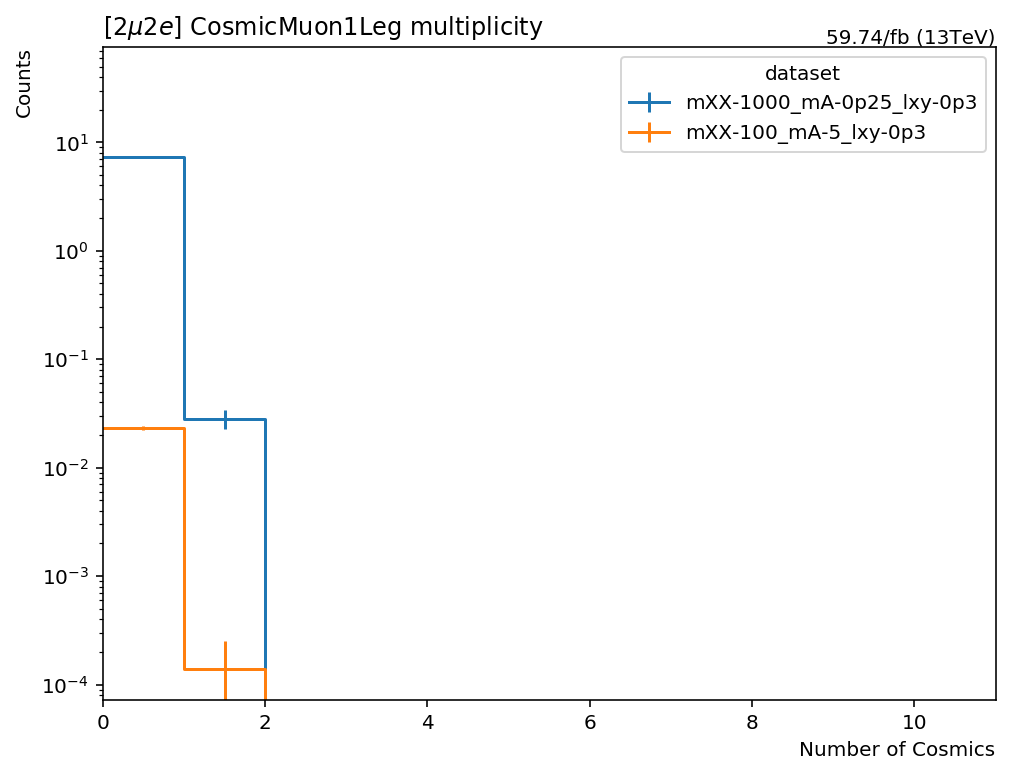

In [72]:
fig, ax = make_signal_plot(out_sig2mu2e['ncosmics'][shortdecay],
                               title='[$2\mu 2e$] CosmicMuon1Leg multiplicity')

In [98]:
hs = out_sig2mu2e['ncosmics'][shortdecay]
for d in hs.identifiers('dataset'):
    h = hs.integrate('dataset', d)
    numer = h.integrate('cnt', slice(0,2)).values()[()]
    total = h.sum('cnt').values()[()]
    frac = 1-numer/total
    print(d, f'{frac*100:.2f}%')

mXX-1000_mA-0p25_lxy-0p3 0.00%
mXX-100_mA-5_lxy-0p3 0.00%


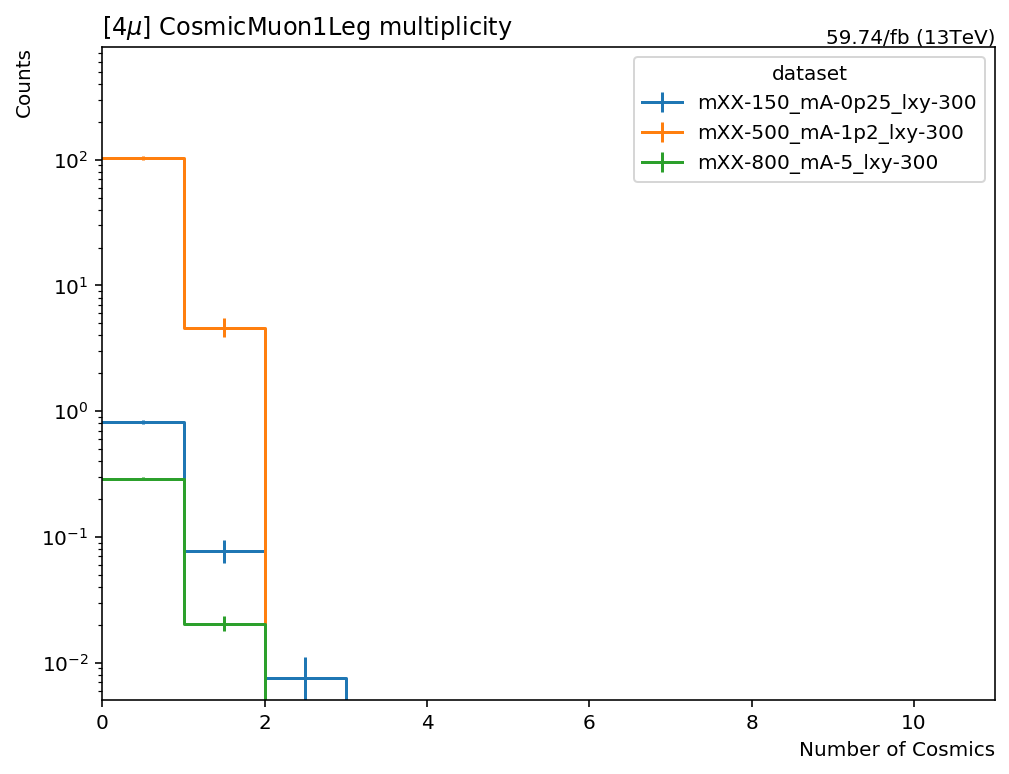

In [78]:
fig, ax = make_signal_plot(out_sig4mu['ncosmics'][sampleSig],
                            title='[$4\mu$] CosmicMuon1Leg multiplicity')

In [99]:
hs = out_sig4mu['ncosmics'][shortdecay]
for d in hs.identifiers('dataset'):
    h = hs.integrate('dataset', d)
    numer = h.integrate('cnt', slice(0,2)).values()[()]
    total = h.sum('cnt').values()[()]
    frac = 1-numer/total
    print(d, f'{frac*100:.2f}%')

mXX-1000_mA-0p25_lxy-0p3 0.10%
mXX-100_mA-5_lxy-0p3 0.25%


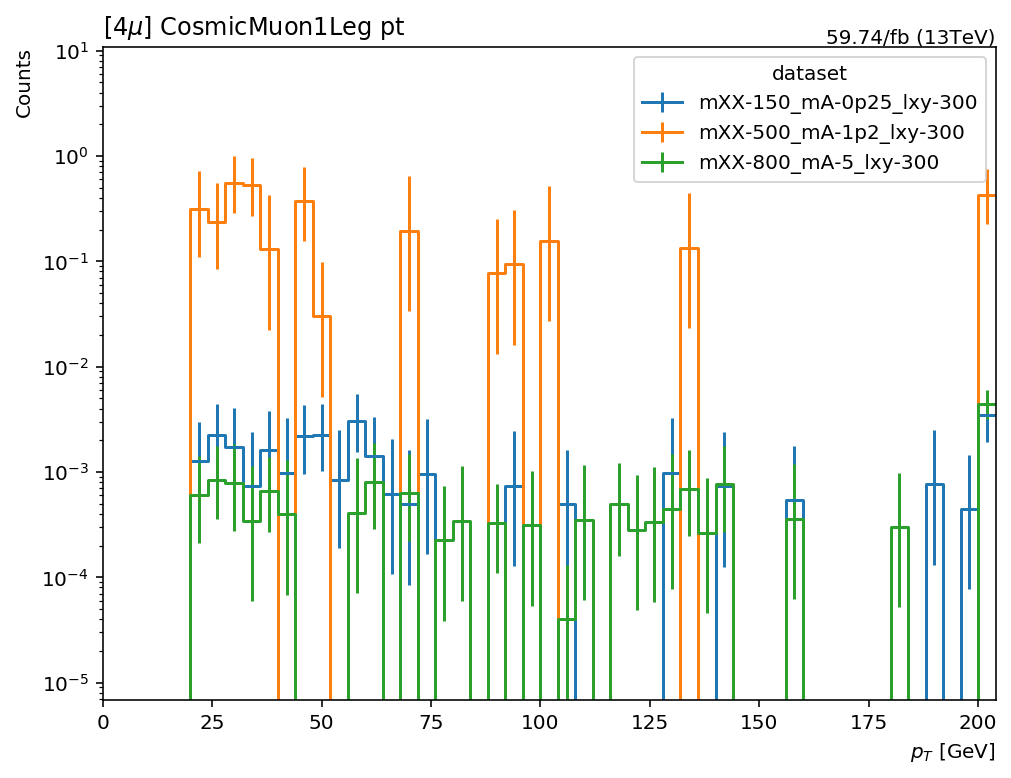

In [45]:
fig, ax = make_signal_plot(out_sig4mu['pt'][sampleSig],
                            title='[$4\mu$] CosmicMuon1Leg pt')

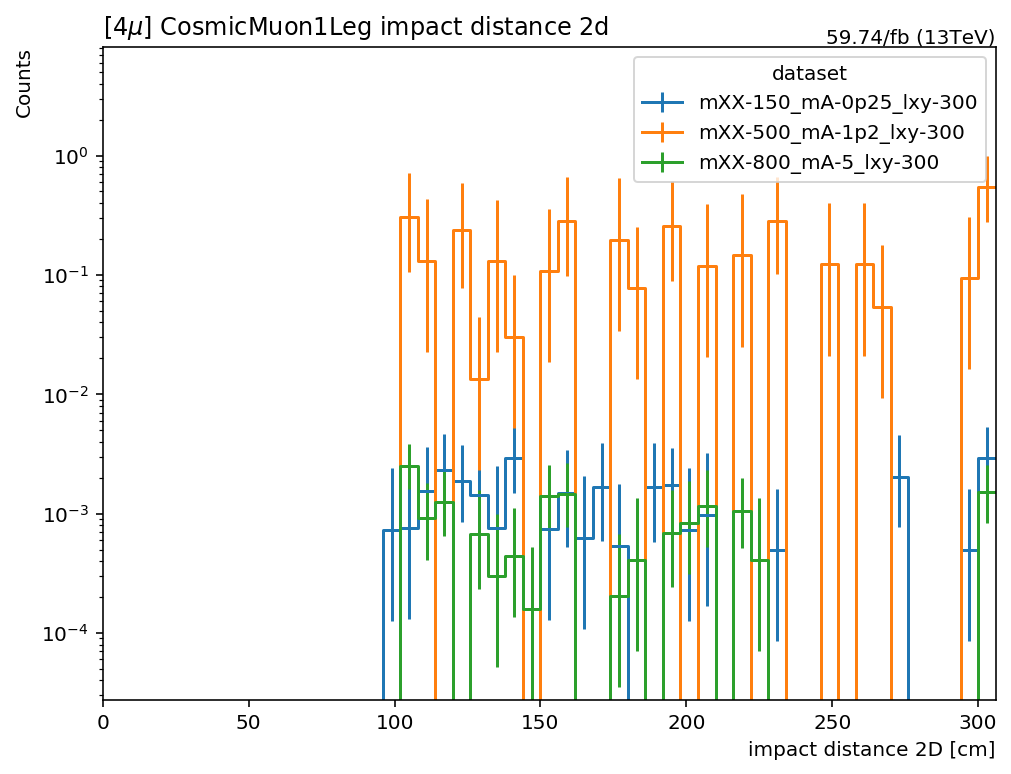

In [46]:
fig, ax = make_signal_plot(out_sig4mu['impact2d'][sampleSig],
                            title='[$4\mu$] CosmicMuon1Leg impact distance 2d')

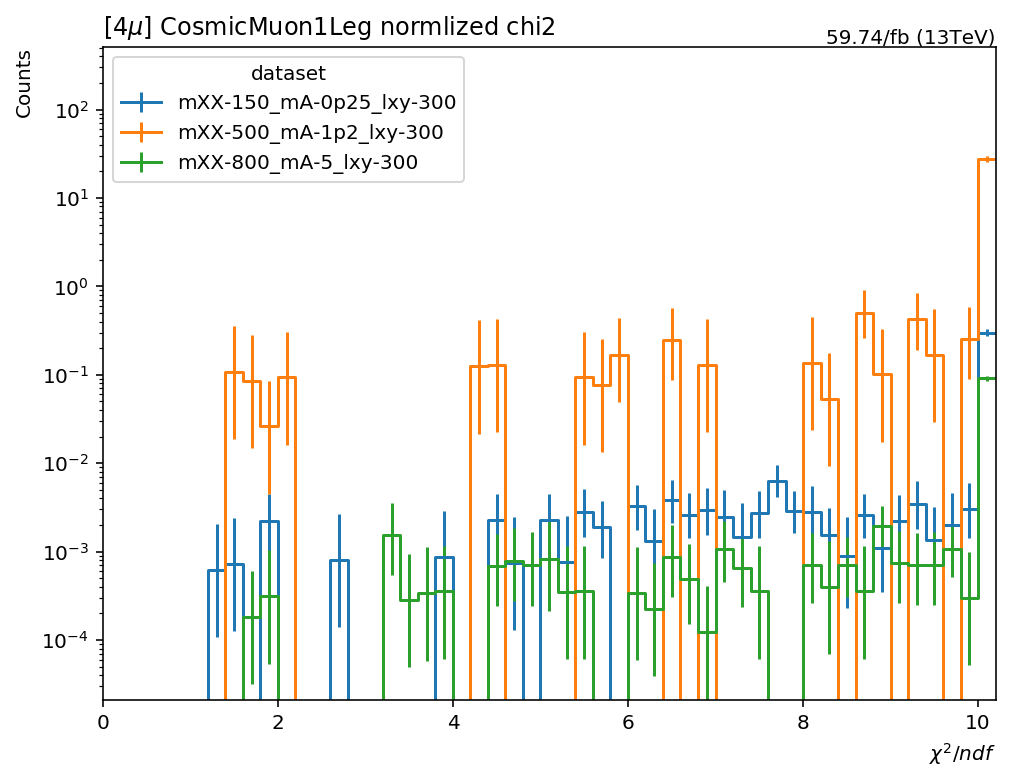

In [52]:
fig, ax = make_signal_plot(out_sig4mu['normchi2'][sampleSig],
                            title='[$4\mu$] CosmicMuon1Leg normlized chi2')

## leptonjet track distance

In [4]:
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self, data_type='sig-2mu2e'):
        self.data_type = data_type
        
        dataset_axis = hist.Cat('dataset', 'dataset')
        dist_axis = hist.Bin('dist', 'any 2 track distance [cm]', 50, 0, 300)
        self._accumulator = processor.dict_accumulator({
            'mindist': hist.Hist('Counts', dataset_axis, dist_axis),
            'maxdist': hist.Hist('Counts', dataset_axis, dist_axis),
        })
        self.pucorrs = get_pu_weights_function()
        ## NOT applied for now
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output

        dataset = df['dataset']
        ## construct weights ##
        wgts = processor.Weights(df.size)
        if self.data_type!='data':
            wgts.add('genw', df['weight'])
            npv = df['trueInteractionNum']
            wgts.add('pileup', *(f(npv) for f in self.pucorrs))

        triggermask = np.logical_or.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
        cosmicpairmask = df['cosmicveto_result']
        wgts.add('cosmicveto', cosmicpairmask)
        pvmask = df['metfilters_PrimaryVertexFilter']
        wgts.add('primaryvtx', pvmask)
        # ...bla bla, other weights goes here

        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'].content,
            py=df['pfjet_p4.fCoordinates.fY'].content,
            pz=df['pfjet_p4.fCoordinates.fZ'].content,
            energy=df['pfjet_p4.fCoordinates.fT'].content,
            pfiso=df['pfjet_pfIsolationNoPU05'].content,
            mintkdist=df['pfjet_pfcands_minTwoTkDist'].content,
            maxtkdist=df['pfjet_pfcands_maxTwoTkDist'].content,
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label, ndsa=ndsa)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        ljdaucharge = awkward.fromiter(df['pfjet_pfcand_charge']).sum()
        leptonjets.add_attributes(qsum=ljdaucharge)
        leptonjets.add_attributes(isneutral=(leptonjets.iseltype | (leptonjets.ismutype&(leptonjets.qsum==0))))
        ## attribute: `nocosmic`
        leptonjets = leptonjets[(leptonjets.pt>30)] # &leptonjets.isneutral
        
        ## __ twoleptonjets__
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]

        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]

        ## channel def ##
        singleMuljEvents = dileptonjets.ismutype.sum()==1
        muljInLeading2Events = (lj0.ismutype | lj1.ismutype).flatten()
        channel_2mu2e = (singleMuljEvents&muljInLeading2Events).astype(int)*1

        doubleMuljEvents = dileptonjets.ismutype.sum()==2
        muljIsLeading2Events = (lj0.ismutype & lj1.ismutype).flatten()
        channel_4mu = (doubleMuljEvents&muljIsLeading2Events).astype(int)*2
        
        channel_ = channel_2mu2e + channel_4mu
        ###########
        
        dileptonjets = dileptonjets[channel_>0]
        wgt = wgt[channel_>0]
        
        ljones = dileptonjets.pt.ones_like()
        output['mindist'].fill(dataset=dataset, dist=dileptonjets.mintkdist.flatten(), weight=(wgt*ljones).flatten())
        output['maxdist'].fill(dataset=dataset, dist=dileptonjets.maxtkdist.flatten(), weight=(wgt*ljones).flatten())
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        for k in origidentity:
            if self.data_type == 'sig-2mu2e':
                accumulator[k].scale(sigSCALE_2mu2e, axis='dataset')
            if self.data_type == 'sig-4mu':
                accumulator[k].scale(sigSCALE_4mu, axis='dataset')
        return accumulator

In [5]:
out_sig2mu2e = processor.run_uproot_job(sigDS_2mu2e,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(data_type='sig-2mu2e'),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                 )
out_sig4mu = processor.run_uproot_job(sigDS_4mu,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(data_type='sig-4mu'),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                 )

#### min any two track distance

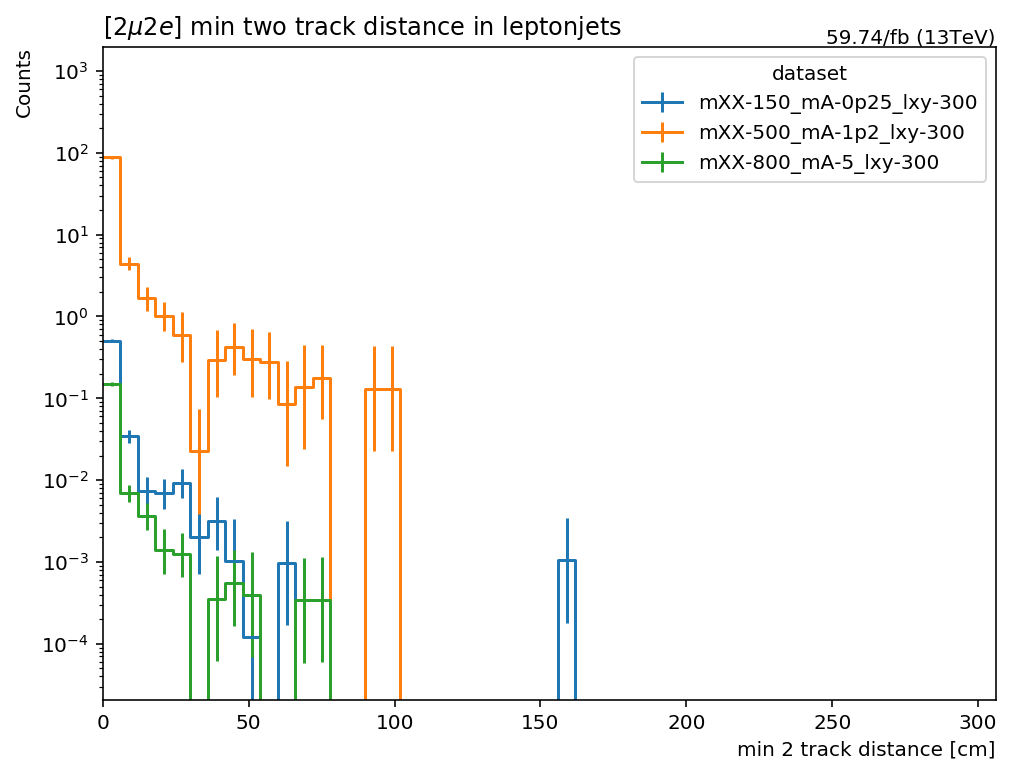

In [14]:
fig, ax = make_signal_plot(out_sig2mu2e['mindist'][sampleSig],
                               title='[$2\mu 2e$] min two track distance in leptonjets')

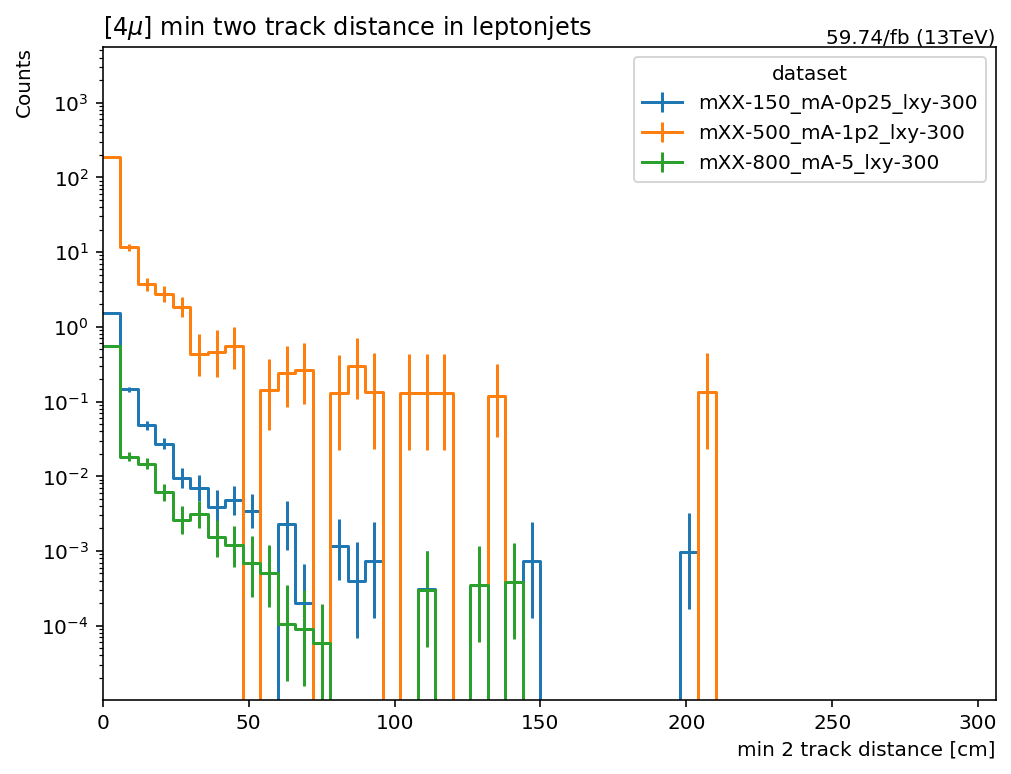

In [11]:
fig, ax = make_signal_plot(out_sig4mu['mindist'][sampleSig],
                               title='[$4\mu$] min two track distance in leptonjets')

In [16]:
# hs = out_sig4mu['mindist'][shortdecay]
hs = out_sig2mu2e['mindist'][shortdecay]

for d in hs.identifiers('dataset'):
    h = hs.integrate('dataset', d)
    numer = h.integrate('dist', slice(0,50)).values()[()]
    total = h.sum('dist').values()[()]
    frac = 1-numer/total
    print(d, f'{frac*100:.2f}%')

mXX-1000_mA-0p25_lxy-0p3 0.01%
mXX-100_mA-5_lxy-0p3 0.00%


#### max two track distance

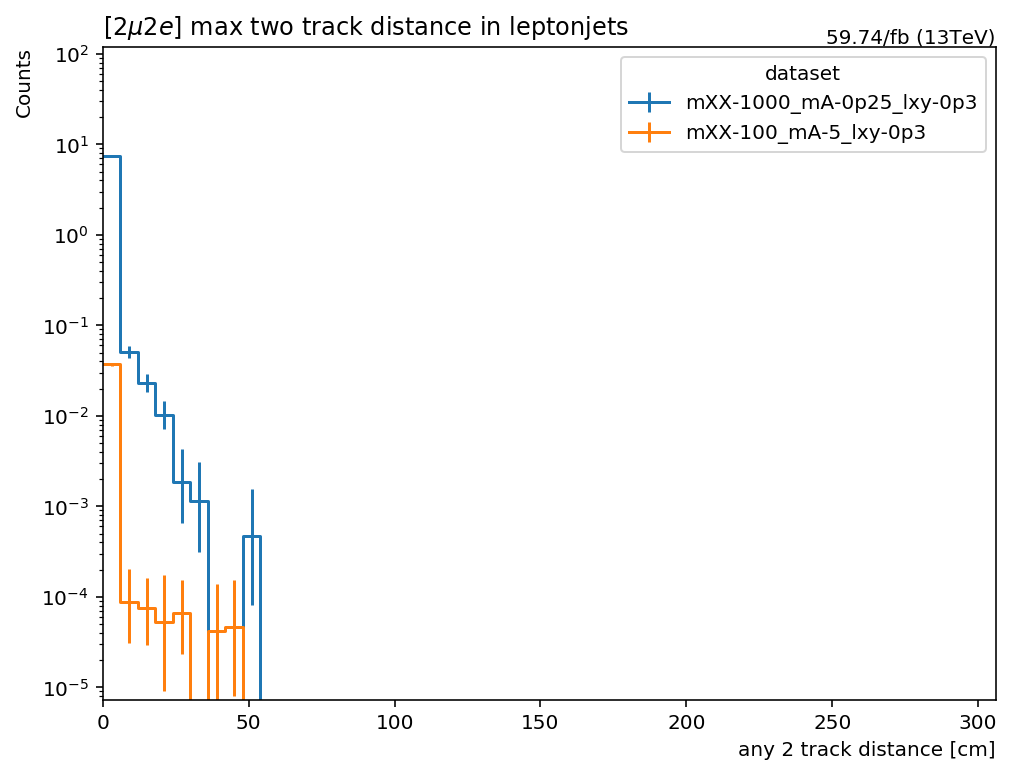

In [8]:
fig, ax = make_signal_plot(out_sig2mu2e['maxdist'][shortdecay], # shortdecay, sampleSig
                               title='[$2\mu 2e$] max two track distance in leptonjets')

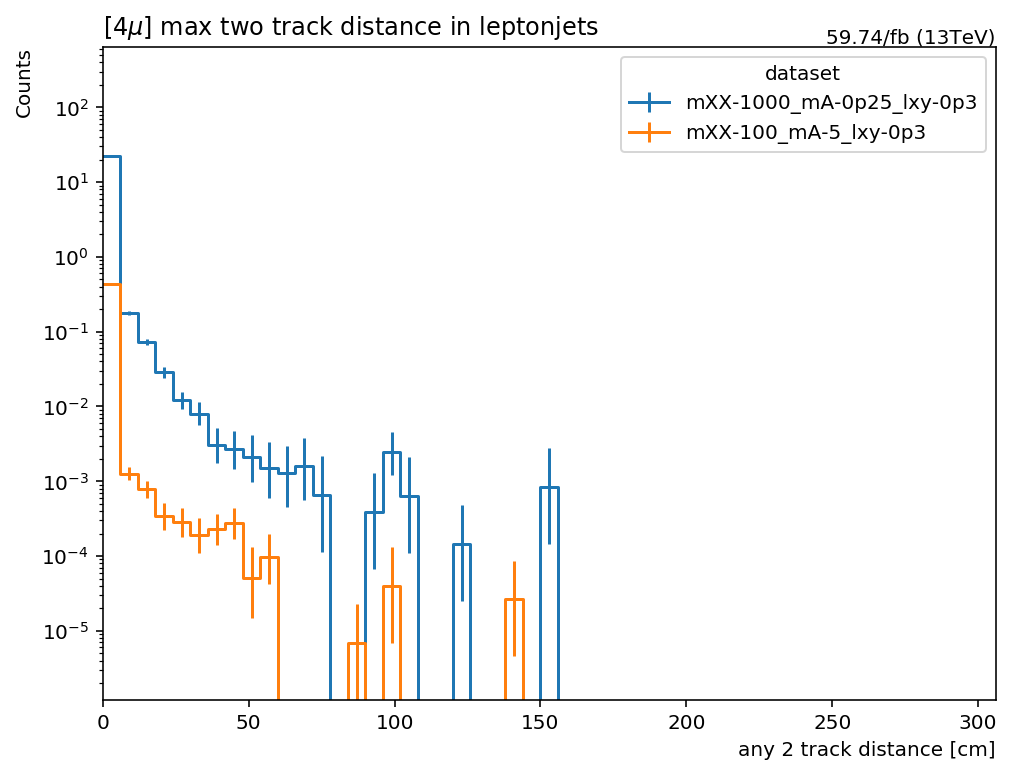

In [9]:
fig, ax = make_signal_plot(out_sig4mu['maxdist'][shortdecay],
                               title='[$4\mu$] max two track distance in leptonjets')